# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


# Labeling the Handwriting Data

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the paths to your image folders
dysgraphic_folder = '/content/drive/MyDrive/Research_Dysgraphia /Preprocessed_Dysgraphic_Words'
non_dysgraphic_folder = '/content/drive/MyDrive/Research_Dysgraphia /preprocessed_Non_Dysgraphic_Letters'

def get_image_paths_and_labels(folder_path, label):
    image_paths = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif")):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)
    return image_paths, labels

# Get dysgraphic image paths and labels
dysgraphic_image_paths, dysgraphic_labels = get_image_paths_and_labels(dysgraphic_folder, label=1)

# Get non-dysgraphic image paths and labels
non_dysgraphic_image_paths, non_dysgraphic_labels = get_image_paths_and_labels(non_dysgraphic_folder, label=0)

# Combine the paths and labels
image_paths = dysgraphic_image_paths + non_dysgraphic_image_paths
labels = dysgraphic_labels + non_dysgraphic_labels

# Create a DataFrame to store the image paths and labels
data = {'Image_Path': image_paths, 'Label': labels}
df = pd.DataFrame(data)

# Shuffle the DataFrame (optional but recommended)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Save the training set to a CSV file
train_csv_path = '/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv'
train_df.to_csv(train_csv_path, index=False)

# Save the testing set to a CSV file
test_csv_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {train_csv_path}")
print(f"Testing dataset saved to {test_csv_path}")


Training dataset saved to /content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv
Testing dataset saved to /content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv


# Train the model with CNN


In [38]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Enable mixed precision for memory savings
mixed_precision.set_global_policy('mixed_float16')

# Load the training dataset
training_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/training_dataset.csv'
train_df = pd.read_csv(training_dataset_path)

# Convert labels to string type for compatibility with ImageDataGenerator
train_df['Label'] = train_df['Label'].astype(str)

# Parameters
image_size = (128, 128)  # Reduced image size
batch_size = 16  # Increased batch size
epochs = 30  # Increased epochs for more training iterations
learning_rate = 0.000005  # Further reduced learning rate
k = 5  # Number of folds for cross-validation

# K-Fold Cross-Validation on training data
train_df['Label_int'] = train_df['Label'].astype(int)  # Convert labels to integers for stratification
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store fold-wise performance metrics
fold_var = 1
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, val_index in skf.split(np.zeros(len(train_df)), train_df['Label_int']):
    training_data = train_df.iloc[train_index].reset_index(drop=True)
    validation_data = train_df.iloc[val_index].reset_index(drop=True)

    # Oversampling the Minority Class Without Augmentation
    # Separate majority and minority classes in training data
    class_counts = training_data['Label_int'].value_counts()
    print(f"Fold {fold_var} - Class distribution before oversampling: {class_counts.to_dict()}")

    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()

    df_majority = training_data[training_data['Label_int'] == majority_class]
    df_minority = training_data[training_data['Label_int'] == minority_class]

    # Oversample minority class
    df_minority_oversampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)

    # Combine majority class with oversampled minority class
    training_data_oversampled = pd.concat([df_majority, df_minority_oversampled], ignore_index=True)

    # Shuffle the oversampled training data
    training_data_oversampled = training_data_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Display class distribution after oversampling
    oversampled_class_counts = training_data_oversampled['Label_int'].value_counts()
    print(f"Fold {fold_var} - Class distribution after oversampling: {oversampled_class_counts.to_dict()}")

    # Build the model
    input_tensor = Input(shape=(128, 128, 3))  # Updated input size
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze more layers to save memory
    for layer in base_model.layers[:-30]:  # Freeze more layers to reduce overfitting
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(x)  # Added L2 regularization and reduced neurons
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure output is float32

    model = Model(inputs=base_model.input, outputs=output)

    # Define metrics
    precision_metric = Precision(name='precision')
    recall_metric = Recall(name='recall')

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision_metric, recall_metric])

    # Prepare data generators for training and validation with data augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,  # Avoid mirroring handwriting
        fill_mode='nearest'
    ).flow_from_dataframe(
        dataframe=training_data_oversampled,
        x_col="Image_Path",
        y_col="Label",
        target_size=image_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=validation_data,
        x_col="Image_Path",
        y_col="Label",
        target_size=image_size,
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False
    )

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)  # Adjusted patience and min_lr
    checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Research_Dysgraphia/dysgraphia_model_fold{fold_var}.keras',
                                 save_best_only=True, monitor='val_loss', mode='min')

    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(training_data_oversampled) // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(validation_data) // batch_size,
        callbacks=[early_stopping, lr_scheduler, checkpoint]
        # No need to pass class_weight since we oversampled
    )

    # Calculate metrics for this fold
    precision = history.history['val_precision'][-1]
    recall = history.history['val_recall'][-1]
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7) if (precision + recall) > 0 else 0
    accuracy = history.history['val_accuracy'][-1]

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    print(f"Fold {fold_var} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
    fold_var += 1

    # Clear session to free up memory
    K.clear_session()

# Calculate average of all folds
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f"Average Accuracy: {average_accuracy}")
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1 Score: {average_f1_score}")


Fold 1 - Class distribution before oversampling: {0: 196, 1: 46}
Fold 1 - Class distribution after oversampling: {0: 196, 1: 196}
Found 392 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 764ms/step - accuracy: 0.5072 - loss: 23.7396 - precision: 0.4913 - recall: 0.5236 - val_accuracy: 0.2083 - val_loss: 23.4435 - val_precision: 0.2083 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5625 - loss: 23.5896 - precision: 0.5000 - recall: 0.7143

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5625 - loss: 23.5896 - precision: 0.5000 - recall: 0.7143 - val_accuracy: 0.1538 - val_loss: 23.4550 - val_precision: 0.1538 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.5882 - loss: 23.5375 - precision: 0.6155 - recall: 0.5911 - val_accuracy: 0.2083 - val_loss: 23.3797 - val_precision: 0.2083 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 23.5105 - precision: 0.7143 - recall: 0.6250 - val_accuracy: 0.1538 - val_loss: 23.3844 - val_precision: 0.1538 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.5944 - loss: 23.4843 - precision: 0.5750 - recall: 0.6578 - val_accuracy: 0.2083 - val_loss: 23.3554 - val_precision: 0.1957 - val_recall: 0.9000 - learning_rate: 5.0000e-06
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 335ms/step - accuracy: 0.4989 - loss: 23.8082 - precision: 0.4705 - recall: 0.4646 - val_accuracy: 0.2292 - val_loss: 23.5834 - val_precision: 0.2292 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:08 6s/step - accuracy: 0.6250 - loss: 23.4943 - precision: 1.0000 - recall: 0.5000

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6250 - loss: 23.4943 - precision: 1.0000 - recall: 0.5000 - val_accuracy: 0.0769 - val_loss: 23.6989 - val_precision: 0.0769 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.4686 - loss: 23.7383 - precision: 0.4922 - recall: 0.4239 - val_accuracy: 0.2292 - val_loss: 23.4275 - val_precision: 0.2292 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2500 - loss: 24.2802 - precision: 0.2000 - recall: 0.1111 - val_accuracy: 0.0769 - val_loss: 23.4951 - val_precision: 0.0769 - val_recall: 1.0000 - learning_rate: 5.0000e-06
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.5124 - loss: 23.6320 - precision: 0.5021 - recall: 0.5517 - val_accuracy: 0.1875 - val_loss: 23.2917 - val_precision: 0.1957 - val_recall: 0.8182 - learning_rate: 5.0000e-06
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 332ms/step - accuracy: 0.5828 - loss: 23.5968 - precision: 0.5759 - recall: 0.5604 - val_accuracy: 0.8125 - val_loss: 23.2880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:03 5s/step - accuracy: 0.5000 - loss: 23.9884 - precision: 1.0000 - recall: 0.4286

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.5000 - loss: 23.9884 - precision: 1.0000 - recall: 0.4286 - val_accuracy: 0.7692 - val_loss: 23.3063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5620 - loss: 23.5496 - precision: 0.5374 - recall: 0.5936 - val_accuracy: 0.2708 - val_loss: 23.3627 - val_precision: 0.1905 - val_recall: 0.8889 - learning_rate: 5.0000e-06
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 23.3012 - precision: 0.6364 - recall: 0.7778 - val_accuracy: 0.2308 - val_loss: 23.3572 - val_precision: 0.1818 - val_recall: 0.6667 - learning_rate: 2.5000e-06
Fold 3 - Accuracy: 0.23076923191547394, Precision: 0.1818181872367859, Recall: 0.6666666865348816, F1 Score: 0.28571426055576954
Fold 4 - Class distribution before oversampling: {0: 196, 1: 47}
Fold 4 - Class distribution after oversampling: {0: 196, 1: 196}
Found 392 validated image fi

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.5441 - loss: 23.6457 - precision: 0.5495 - recall: 0.5453 - val_accuracy: 0.8333 - val_loss: 23.2916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 23.2891 - precision: 0.8571 - recall: 0.6667

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.7500 - loss: 23.2891 - precision: 0.8571 - recall: 0.6667 - val_accuracy: 0.7500 - val_loss: 23.2850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.5348 - loss: 23.6845 - precision: 0.5470 - recall: 0.5434 - val_accuracy: 0.8333 - val_loss: 23.1640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 23.6224 - precision: 0.5556 - recall: 0.6250 - val_accuracy: 0.7500 - val_loss: 23.1924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.5045 - loss: 23.6679 - precision: 0.4931 - recall: 0.4934 - val_accuracy: 0.8333 - val_loss: 23.0937 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 6/30
24/24 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 580ms/step - accuracy: 0.5384 - loss: 23.6600 - precision: 0.5554 - recall: 0.4982 - val_accuracy: 0.2500 - val_loss: 23.3607 - val_precision: 0.2045 - val_recall: 0.9000 - learning_rate: 5.0000e-06
Epoch 2/30
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4375 - loss: 23.6999 - precision: 0.5000 - recall: 0.4444

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4375 - loss: 23.6999 - precision: 0.5000 - recall: 0.4444 - val_accuracy: 0.0000e+00 - val_loss: 23.3771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6227 - loss: 23.4775 - precision: 0.6261 - recall: 0.6402 - val_accuracy: 0.6250 - val_loss: 23.2729 - val_precision: 0.2143 - val_recall: 0.3000 - learning_rate: 5.0000e-06
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 23.2840 - precision: 0.4286 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 23.2777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.5761 - loss: 23.4024 - precision: 0.5744 - recall: 0.5671 - val_accuracy: 0.6458 - val_loss: 23.2141 - val_precision: 0.2667 - val_recall: 0.4000 - learning_rate: 5.0000e-06
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
image_size = (128, 128)
batch_size = 8

# Load the testing dataset
testing_dataset_path = '/content/drive/MyDrive/Research_Dysgraphia/testing_dataset.csv'
test_df = pd.read_csv(testing_dataset_path)
test_df['Label'] = test_df['Label'].astype(str)

# Prepare the testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Label",
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Load the best model
best_model_path = f'/content/drive/MyDrive/Research_Dysgraphia/dysgraphia_model_fold{4}.keras'
model = tf.keras.models.load_model(best_model_path)

# Evaluate the model on the testing dataset
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1 Score: {test_f1_score}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# True labels
true_labels = test_generator.classes

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

target_names = ['Non-Dysgraphic', 'Dysgraphic']
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:")
print(report)


Found 76 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.9621 - loss: 22.0970 - precision: 0.8943 - recall: 0.9002
Testing Loss: 22.082168579101562
Testing Accuracy: 0.9605262875556946
Testing Precision: 0.875
Testing Recall: 0.9333333373069763
Testing F1 Score: 0.9032257583643517
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step
Confusion Matrix:
[[59  2]
 [ 1 14]]
Classification Report:
                precision    recall  f1-score   support

Non-Dysgraphic       0.98      0.97      0.98        61
    Dysgraphic       0.88      0.93      0.90        15

      accuracy                           0.96        76
     macro avg       0.93      0.95      0.94        76
  weighted avg       0.96      0.96      0.96        76



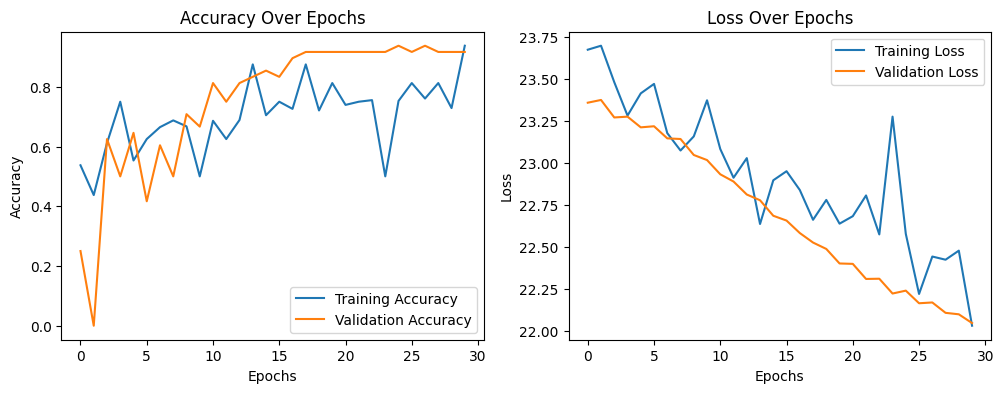

In [39]:
import matplotlib.pyplot as plt

# Assuming `history` is the returned object from `model.fit()`
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

